# Task2b

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
pip install scanpy

In [7]:
import scanpy as sc
import numpy as np
import pandas as pd
import random
import scipy.sparse as sp

adata = sc.read_h5ad("/content/drive/MyDrive/Zhuoyao/Course/ComputationalStemCell/final/data/PBMC_simulated_cnas_041025.h5ad")

clean_mask = (adata.obs['simulated_cnvs'] == '')
adata_clean = adata[clean_mask].copy()

print(f"clean cells: {adata_clean.n_obs} cells, {adata_clean.n_vars} genes")


clean cells: 6312 cells, 20104 genes


In [8]:
print(adata_clean.obs['simulated_cnvs'])

AAACCCAAGCGCCCAT-1     
AAACCCAAGGTTCCGC-1     
AAACCCACAGGTATGG-1     
AAACCCACATAGTCAC-1     
AAACCCACATCCAATG-1     
                     ..
TTTGTTGCATCTGCGG-1     
TTTGTTGGTCTGTAAC-1     
TTTGTTGGTGCGTCGT-1     
TTTGTTGGTTTGAACC-1     
TTTGTTGTCTTACTGT-1     
Name: simulated_cnvs, Length: 6312, dtype: category
Categories (1, object): ['']


In [9]:
# simulation plan
simulation_plan = [
    # loss (Chr5)
    {
        'cell_type': 'CD14 monocyte',
        'chromosome': '5',
        'start': 10000000,  # 10Mb
        'end': 20000000,    # 20Mb
        'cna_type': 'loss',
        'fraction': 0.15    # simulate 15% monocytes
    },
    # gain (Chr11)
    {
        'cell_type': 'CD4 T cell',
        'chromosome': '11',
        'start': 30000000,
        'end': 40000000,
        'cna_type': 'gain',
        'fraction': 0.25
    },
    # homozygous loss (Chr3)
    {
        'cell_type': 'B cell',
        'chromosome': '3',
        'start': 50000000,
        'end': 80000000,
        'cna_type': 'loss',  #"deep loss"
        'fraction': 0.2
    }
]


In [10]:
def simulate_cnas(adata, simulation_plan, layer='counts'):
    adata = adata.copy()
    counts = adata.layers[layer]
    if sp.issparse(counts):
        counts = counts.toarray()

    sim_labels = np.array([""] * adata.n_obs, dtype=object)

    for plan in simulation_plan:
        ct = plan['cell_type']
        chr = plan['chromosome']
        start, end = plan['start'], plan['end']
        cna_type = plan['cna_type']
        frac = plan['fraction']

        # select cells
        mask = (adata.obs['cell_type'] == ct)
        idxs = np.where(mask)[0]
        n_select = int(len(idxs) * frac)
        selected = np.random.choice(idxs, n_select, replace=False)

        # select genes
        gene_mask = (adata.var['chromosome'] == chr) & \
                    (adata.var['start'] >= start) & (adata.var['end'] <= end)
        gene_idxs = np.where(gene_mask)[0]

        if cna_type == 'loss':
            counts[np.ix_(selected, gene_idxs)] = 0
        elif cna_type == 'gain':
            counts[np.ix_(selected, gene_idxs)] *= 4
        else:
            raise ValueError(f"Unknown cna_type {cna_type}")

        # update labels
        for i in selected:
            if sim_labels[i] == "":
                sim_labels[i] = f"{chr}:{start}-{end}({cna_type})"
            else:
                sim_labels[i] += f"; {chr}:{start}-{end}({cna_type})"

    adata.layers[layer] = counts
    adata.obs['simulated_cnvs'] = sim_labels
    return adata


In [11]:
adata_simulated = simulate_cnas(adata_clean, simulation_plan)
print(f"simulated cna cells number: {(adata_simulated.obs['simulated_cnvs'] != '').sum()}")
print(adata_simulated.obs['simulated_cnvs'].value_counts())

simulated cna cells number: 874
simulated_cnvs
                              5438
11:30000000-40000000(gain)     455
3:50000000-80000000(loss)      290
5:10000000-20000000(loss)      129
Name: count, dtype: int64


In [ ]:
save_path = "/content/drive/MyDrive/Zhuoyao/Course/ComputationalStemCell/final/data/PBMC_simulated_cnas_task2b_v1.h5ad"
adata_simulated.write(save_path)

print(f"save to: {save_path}")

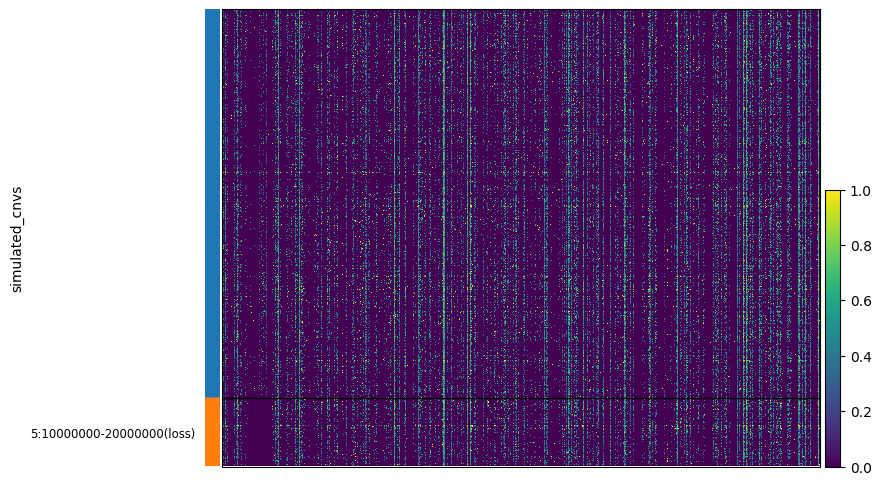

In [12]:
import scanpy as sc

# extract CD14 monocyte + Chr5 gene expression
ad_cd14 = adata_simulated[adata_simulated.obs["cell_type"] == "CD14 monocyte"]
ad_chr5 = ad_cd14[:, ad_cd14.var["chromosome"] == "5"].copy()

# simulated_cnvs group
sc.pl.heatmap(ad_chr5, var_names=ad_chr5.var_names,
              groupby="simulated_cnvs",
              layer="counts", log=True,
              standard_scale="var", show=True)


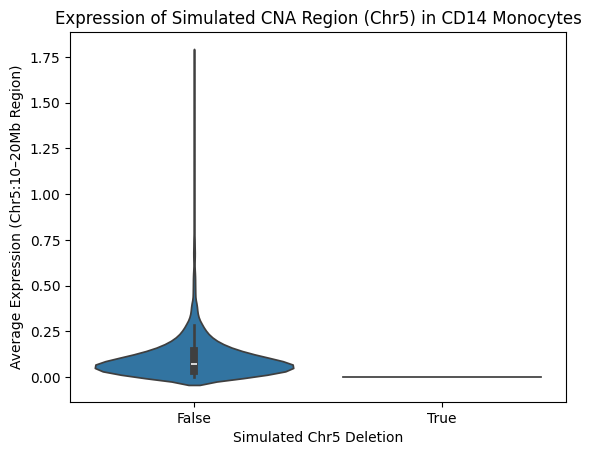

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# extract simulated genes
simulated_region = (adata_simulated.var["chromosome"] == "5") & \
                   (adata_simulated.var["start"] >= 10_000_000) & \
                   (adata_simulated.var["end"] <= 20_000_000)

genes_in_region = adata_simulated.var_names[simulated_region]

# calculate each cell average expression of genes
expr = adata_simulated[:, genes_in_region].layers["counts"].mean(axis=1)
adata_simulated.obs["avg_expr_chr5_sim"] = expr

import seaborn as sns
import matplotlib.pyplot as plt

adata_simulated.obs["has_chr5_del"] = adata_simulated.obs["simulated_cnvs"].str.contains("5:10000000-20000000")

sns.violinplot(data=adata_simulated.obs,
               x="has_chr5_del", y="avg_expr_chr5_sim")
plt.xlabel("Simulated Chr5 Deletion")
plt.ylabel("Average Expression (Chr5:10–20Mb Region)")
plt.title("Expression of Simulated CNA Region (Chr5) in CD14 Monocytes")
plt.show()


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

cna_list = [
    {
        "name": "Chr5:10–20Mb\n(hemizygous loss)",
        "chr": "5",
        "start": 10_000_000,
        "end": 20_000_000,
        "label": "5:10000000-20000000"
    },
    {
        "name": "Chr11:30–40Mb\n(gain)",
        "chr": "11",
        "start": 30_000_000,
        "end": 40_000_000,
        "label": "11:30000000-40000000"
    },
    {
        "name": "Chr3:50–80Mb\n(homozygous loss)",
        "chr": "3",
        "start": 50_000_000,
        "end": 80_000_000,
        "label": "3:50000000-80000000"
    }
]

plot_df = []

for cna in cna_list:
    chr_mask = (adata_simulated.var["chromosome"] == cna["chr"]) & \
               (adata_simulated.var["start"] >= cna["start"]) & \
               (adata_simulated.var["end"] <= cna["end"])

    genes = adata_simulated.var_names[chr_mask]
    if len(genes) == 0:
        print(f"No genes found for {cna['name']}")
        continue

    avg_expr = adata_simulated[:, genes].layers["counts"].mean(axis=1)

    has_cna = adata_simulated.obs["simulated_cnvs"].str.contains(cna["label"])

    temp_df = pd.DataFrame({
        "Average Expression": avg_expr,
        "Simulated CNA": has_cna.map({True: "True", False: "False"}),
        "CNA Type": cna["name"]
    })
    plot_df.append(temp_df)

plot_df = pd.concat(plot_df, ignore_index=True)


<ipython-input-18-fc973e757fd2>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=plot_df, x="Simulated CNA", y="Average Expression",


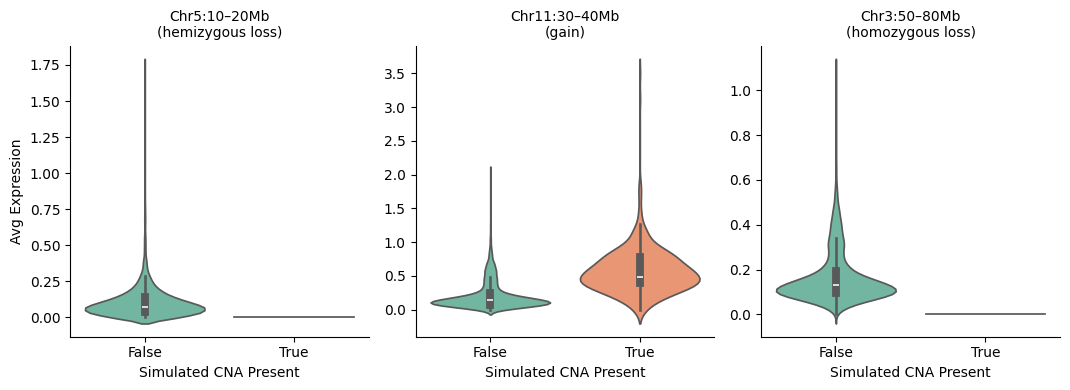

In [18]:
g = sns.catplot(data=plot_df, x="Simulated CNA", y="Average Expression",
                col="CNA Type", kind="violin", inner="box", height=4, aspect=0.9,
                palette="Set2", sharey=False)
g.set_titles("{col_name}")
g.set_axis_labels("Simulated CNA Present", "Avg Expression")
g.tight_layout()
plt.show()


## try compare with infercnvpy

In [78]:
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score
import sys
sys.path.append('../src')  # Adjust this path as necessary
import cna_tool
from cna_tool import infer_cnas_from_scrna
from cna_tool.tl import run_cna_evaluation
import numpy as np



In [73]:
adata_simulated = sc.read_h5ad("../data/PBMC_simulated_cnas_task2b_v1.h5ad")

In [74]:
# 2) Build a string‐typed reference column
adata_simulated.obs["reference"] = [
    "normal" if x=="" else "tumor"
    for x in adata_simulated.obs["simulated_cnvs"]
]

In [ ]:

# Define parameter grid
param_grid = [
    {'window': w, 'gain_thr': g, 'loss_thr': -g, 'norm_method': 'log2_ratio'}
    for w in [50, 100, 150, 200]
    for g in [0.05, 0.1, 0.15, 0.2]
]

# Store results
results = []

# Evaluate your method
def evaluate_our_method(adata, params):
    """
    Wrapper that returns only F1 score from our full CNA evaluation.
    """
    metrics = run_cna_evaluation(adata, params)
    return metrics["f1"]


In [ ]:
def call_cna_from_infercnv(adata, threshold=0.2):
    """
    Converts infercnvpy's X_cnv sparse matrix into binary CNA presence per cell.

    A cell is labeled '1' if any gene exceeds +/- threshold in smoothed CNV profile.

    Returns:
    - np.array: Binary vector of shape (n_cells,)
    """
    from scipy.sparse import issparse

    X_cnv = adata.obsm["X_cnv"]

    # Convert sparse to dense array if needed
    if issparse(X_cnv):
        X_cnv = X_cnv.toarray()

    # Compute CNA presence
    cna_present = (np.abs(X_cnv) > threshold).any(axis=1)

    return cna_present.astype(int)


def evaluate_infercnvpy(adata, params):
    adata_inf = adata.copy()
    adata_inf.obs["reference"] = ["normal" if str(x).strip() == "" else "tumor" for x in adata_inf.obs["simulated_cnvs"]]

    adata_inf = adata_inf[:, adata_inf.var.dropna(subset=["chromosome", "start", "end"]).index].copy()
    adata_inf.var["chromosome"] = adata_inf.var["chromosome"].astype(str)
    adata_inf.var["chromosome"] = adata_inf.var["chromosome"].apply(lambda x: f"chr{x}" if not x.startswith("chr") else x)
    adata_inf.var = adata_inf.var.sort_values(["chromosome", "start"])
    adata_inf = adata_inf[:, adata_inf.var.index].copy()

    cnv.tl.infercnv(
        adata_inf,
        reference_key="reference",
        reference_cat=["normal"],
        window_size=params['window'],
        step=10,
        dynamic_threshold=params['gain_thr'],
        exclude_chromosomes=["chrX", "chrY"],
        chunksize=500,
        n_jobs=4,
        inplace=True
    )

    y_true = adata_inf.obs["simulated_cnvs"].apply(lambda x: 0 if str(x).strip() == '' else 1)
    y_pred = call_cna_from_infercnv(adata_inf, threshold=params['gain_thr'])

    return f1_score(y_true, y_pred)



In [ ]:
for params in param_grid:
    print(f"Evaluating {params}")
    try:
        f1_ours = evaluate_our_method(adata_simulated, params)
        f1_infercnvpy = evaluate_infercnvpy(adata_simulated, params)
        print(f"F1 Score (Ours): {f1_ours}")
        print(f"F1 Score (infercnvpy): {f1_infercnvpy}")

        results.append({
            'window': params['window'],
            'threshold': params['gain_thr'],
            'f1_ours': f1_ours,
            'f1_infercnvpy': f1_infercnvpy,
        })

    except Exception as e:
        print(f"Skipped params {params} due to error: {e}")

Evaluating {'window': 50, 'gain_thr': 0.05, 'loss_thr': -0.05, 'norm_method': 'log2_ratio'}


c:\Users\clark\OneDrive\Documents\GitHub\CNA_tool\notebooks\../src\cna_tool\utils.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
100%|██████████| 13/13 [00:02<00:00,  4.49it/s]


Skipped params {'window': 50, 'gain_thr': 0.05, 'loss_thr': -0.05, 'norm_method': 'log2_ratio'} due to error: call_cna_from_infercnv() got an unexpected keyword argument 'threshold2'
Evaluating {'window': 50, 'gain_thr': 0.1, 'loss_thr': -0.1, 'norm_method': 'log2_ratio'}


c:\Users\clark\OneDrive\Documents\GitHub\CNA_tool\notebooks\../src\cna_tool\utils.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
100%|██████████| 13/13 [00:02<00:00,  4.51it/s]


Skipped params {'window': 50, 'gain_thr': 0.1, 'loss_thr': -0.1, 'norm_method': 'log2_ratio'} due to error: call_cna_from_infercnv() got an unexpected keyword argument 'threshold2'
Evaluating {'window': 50, 'gain_thr': 0.15, 'loss_thr': -0.15, 'norm_method': 'log2_ratio'}


c:\Users\clark\OneDrive\Documents\GitHub\CNA_tool\notebooks\../src\cna_tool\utils.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
100%|██████████| 13/13 [00:02<00:00,  4.56it/s]


Skipped params {'window': 50, 'gain_thr': 0.15, 'loss_thr': -0.15, 'norm_method': 'log2_ratio'} due to error: call_cna_from_infercnv() got an unexpected keyword argument 'threshold2'
Evaluating {'window': 50, 'gain_thr': 0.2, 'loss_thr': -0.2, 'norm_method': 'log2_ratio'}


c:\Users\clark\OneDrive\Documents\GitHub\CNA_tool\notebooks\../src\cna_tool\utils.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
100%|██████████| 13/13 [00:02<00:00,  4.50it/s]


Skipped params {'window': 50, 'gain_thr': 0.2, 'loss_thr': -0.2, 'norm_method': 'log2_ratio'} due to error: call_cna_from_infercnv() got an unexpected keyword argument 'threshold2'
Evaluating {'window': 100, 'gain_thr': 0.05, 'loss_thr': -0.05, 'norm_method': 'log2_ratio'}


c:\Users\clark\OneDrive\Documents\GitHub\CNA_tool\notebooks\../src\cna_tool\utils.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
100%|██████████| 13/13 [00:02<00:00,  4.46it/s]


Skipped params {'window': 100, 'gain_thr': 0.05, 'loss_thr': -0.05, 'norm_method': 'log2_ratio'} due to error: call_cna_from_infercnv() got an unexpected keyword argument 'threshold2'
Evaluating {'window': 100, 'gain_thr': 0.1, 'loss_thr': -0.1, 'norm_method': 'log2_ratio'}


c:\Users\clark\OneDrive\Documents\GitHub\CNA_tool\notebooks\../src\cna_tool\utils.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
100%|██████████| 13/13 [00:02<00:00,  4.51it/s]


Skipped params {'window': 100, 'gain_thr': 0.1, 'loss_thr': -0.1, 'norm_method': 'log2_ratio'} due to error: call_cna_from_infercnv() got an unexpected keyword argument 'threshold2'
Evaluating {'window': 100, 'gain_thr': 0.15, 'loss_thr': -0.15, 'norm_method': 'log2_ratio'}


c:\Users\clark\OneDrive\Documents\GitHub\CNA_tool\notebooks\../src\cna_tool\utils.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
100%|██████████| 13/13 [00:02<00:00,  4.57it/s]


Skipped params {'window': 100, 'gain_thr': 0.15, 'loss_thr': -0.15, 'norm_method': 'log2_ratio'} due to error: call_cna_from_infercnv() got an unexpected keyword argument 'threshold2'
Evaluating {'window': 100, 'gain_thr': 0.2, 'loss_thr': -0.2, 'norm_method': 'log2_ratio'}


c:\Users\clark\OneDrive\Documents\GitHub\CNA_tool\notebooks\../src\cna_tool\utils.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
100%|██████████| 13/13 [00:02<00:00,  4.49it/s]


Skipped params {'window': 100, 'gain_thr': 0.2, 'loss_thr': -0.2, 'norm_method': 'log2_ratio'} due to error: call_cna_from_infercnv() got an unexpected keyword argument 'threshold2'
Evaluating {'window': 150, 'gain_thr': 0.05, 'loss_thr': -0.05, 'norm_method': 'log2_ratio'}


c:\Users\clark\OneDrive\Documents\GitHub\CNA_tool\notebooks\../src\cna_tool\utils.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
100%|██████████| 13/13 [00:02<00:00,  4.43it/s]


Skipped params {'window': 150, 'gain_thr': 0.05, 'loss_thr': -0.05, 'norm_method': 'log2_ratio'} due to error: call_cna_from_infercnv() got an unexpected keyword argument 'threshold2'
Evaluating {'window': 150, 'gain_thr': 0.1, 'loss_thr': -0.1, 'norm_method': 'log2_ratio'}


c:\Users\clark\OneDrive\Documents\GitHub\CNA_tool\notebooks\../src\cna_tool\utils.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
100%|██████████| 13/13 [00:02<00:00,  4.43it/s]


Skipped params {'window': 150, 'gain_thr': 0.1, 'loss_thr': -0.1, 'norm_method': 'log2_ratio'} due to error: call_cna_from_infercnv() got an unexpected keyword argument 'threshold2'
Evaluating {'window': 150, 'gain_thr': 0.15, 'loss_thr': -0.15, 'norm_method': 'log2_ratio'}


c:\Users\clark\OneDrive\Documents\GitHub\CNA_tool\notebooks\../src\cna_tool\utils.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
100%|██████████| 13/13 [00:02<00:00,  4.47it/s]


Skipped params {'window': 150, 'gain_thr': 0.15, 'loss_thr': -0.15, 'norm_method': 'log2_ratio'} due to error: call_cna_from_infercnv() got an unexpected keyword argument 'threshold2'
Evaluating {'window': 150, 'gain_thr': 0.2, 'loss_thr': -0.2, 'norm_method': 'log2_ratio'}


c:\Users\clark\OneDrive\Documents\GitHub\CNA_tool\notebooks\../src\cna_tool\utils.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
100%|██████████| 13/13 [00:02<00:00,  4.42it/s]


Skipped params {'window': 150, 'gain_thr': 0.2, 'loss_thr': -0.2, 'norm_method': 'log2_ratio'} due to error: call_cna_from_infercnv() got an unexpected keyword argument 'threshold2'
Evaluating {'window': 200, 'gain_thr': 0.05, 'loss_thr': -0.05, 'norm_method': 'log2_ratio'}


c:\Users\clark\OneDrive\Documents\GitHub\CNA_tool\notebooks\../src\cna_tool\utils.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
100%|██████████| 13/13 [00:03<00:00,  4.29it/s]


Skipped params {'window': 200, 'gain_thr': 0.05, 'loss_thr': -0.05, 'norm_method': 'log2_ratio'} due to error: call_cna_from_infercnv() got an unexpected keyword argument 'threshold2'
Evaluating {'window': 200, 'gain_thr': 0.1, 'loss_thr': -0.1, 'norm_method': 'log2_ratio'}


c:\Users\clark\OneDrive\Documents\GitHub\CNA_tool\notebooks\../src\cna_tool\utils.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
100%|██████████| 13/13 [00:02<00:00,  4.42it/s]


Skipped params {'window': 200, 'gain_thr': 0.1, 'loss_thr': -0.1, 'norm_method': 'log2_ratio'} due to error: call_cna_from_infercnv() got an unexpected keyword argument 'threshold2'
Evaluating {'window': 200, 'gain_thr': 0.15, 'loss_thr': -0.15, 'norm_method': 'log2_ratio'}


c:\Users\clark\OneDrive\Documents\GitHub\CNA_tool\notebooks\../src\cna_tool\utils.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
100%|██████████| 13/13 [00:02<00:00,  4.43it/s]


Skipped params {'window': 200, 'gain_thr': 0.15, 'loss_thr': -0.15, 'norm_method': 'log2_ratio'} due to error: call_cna_from_infercnv() got an unexpected keyword argument 'threshold2'
Evaluating {'window': 200, 'gain_thr': 0.2, 'loss_thr': -0.2, 'norm_method': 'log2_ratio'}


c:\Users\clark\OneDrive\Documents\GitHub\CNA_tool\notebooks\../src\cna_tool\utils.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, sub in var.groupby('chromosome'):
100%|██████████| 13/13 [00:02<00:00,  4.33it/s]

Skipped params {'window': 200, 'gain_thr': 0.2, 'loss_thr': -0.2, 'norm_method': 'log2_ratio'} due to error: call_cna_from_infercnv() got an unexpected keyword argument 'threshold2'


C:\Users\clark\AppData\Local\Temp\ipykernel_49068\3588631284.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar


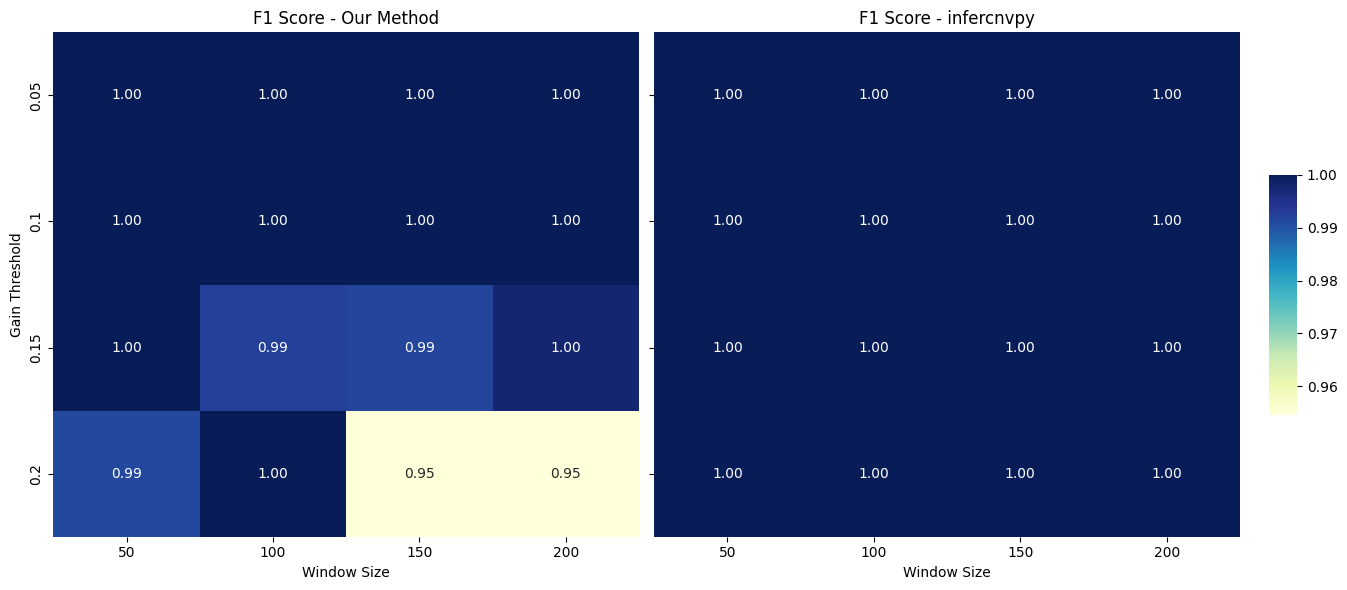

In [9]:
# Convert to DataFrame
df = pd.DataFrame(results)

# Pivot tables
pivot_ours = df.pivot(index='threshold', columns='window', values='f1_ours')
pivot_infercnvpy = df.pivot(index='threshold', columns='window', values='f1_infercnvpy')

# Determine shared color scale range
vmin = min(pivot_ours.min().min(), pivot_infercnvpy.min().min())
vmax = max(pivot_ours.max().max(), pivot_infercnvpy.max().max())

# Create side-by-side plots with shared color bar
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
cbar_ax = fig.add_axes([.91, .3, .02, .4])  # Position for colorbar

sns.heatmap(pivot_ours, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[0],
            cbar=True, cbar_ax=cbar_ax, vmin=vmin, vmax=vmax)
axes[0].set_title("F1 Score - Our Method")
axes[0].set_xlabel("Window Size")
axes[0].set_ylabel("Gain Threshold")

sns.heatmap(pivot_infercnvpy, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[1],
            cbar=False, vmin=vmin, vmax=vmax)
axes[1].set_title("F1 Score - infercnvpy")
axes[1].set_xlabel("Window Size")
axes[1].set_ylabel("")

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar
plt.show()
